# Malaria Image Detection - Classification

**PROBLEM STATEMENT :** We have a collection consisting of 19290 blood-cell images out of which 50% are Maleria-Parasite affected cells and 50% are healthy. We have to build a classifier model which can classify the cells based on their characteristics. 

We have a .CSV file (train.csv) which contains the title of each image in the column **filename** and the column **label** tells us which class the image blongs to, there are two classes-
1. malaria
2. healthy

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


from skimage.io import imshow, imread, imsave
from skimage.transform import resize
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

%matplotlib inline
warnings.filterwarnings('ignore')

## (A). EDA
Let's feed the file location to the base_dir variable

In [2]:
base_directory = os.path.join('C:/Users/LENOVO/Downloads/Malaria_Detection_Project/cell_images')

Let's import train.csv and look at its contents

In [3]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(19290, 2)


,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria


Let's look at the class distribution

In [4]:
df['label'].value_counts()

malaria    9645
healthy    9645
Name: label, dtype: int64

This is a balanced class problem. We can use Accuracy as an evaluation metric. Now, Let's look at some of the images we're going to procees.

<Figure size 4000x4000 with 0 Axes>

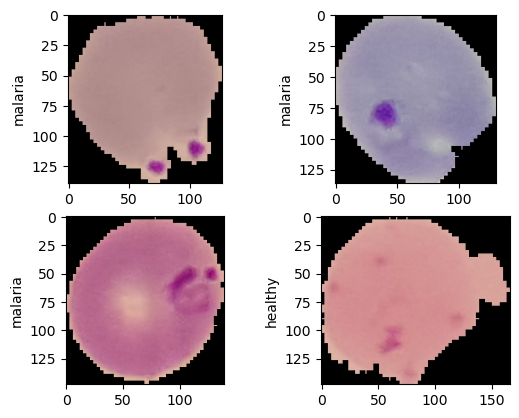

In [5]:
plt.figure(figsize= (40, 40), dpi= 100)
fig, ax = plt.subplots(2,2)

for i in range(0,2):
    for j in range(0,2):
        
        image = imread(os.path.join(base_directory, df['filename'][2*i+3*j]))
        
        ax[i,j].imshow(image)
        ax[i,j].set_ylabel(df['label'][2*i+3*j])

The infected cells are visibaly distinguishable from the healthy cells. Let's preprocess the data now.

## (B). Data Preprocessing

### 1. Variable Encoding

To train the model we will encode the traget variable into different numerical classes.

In [6]:
LE = LabelEncoder()

labels = LE.fit_transform(df['label'])

df['label'] = labels

class_mapping = dict(zip(LE.classes_, labels))

print(class_mapping)

{'healthy': 1, 'malaria': 0}


### 2. HOG Features Extraction 

First, We'll divide the data into training and test sets.

Then, To extract HOG features, it's necessary that all the images are of same dimensions (128x64). lets check if we already have the dimensions in order or do we need to convert it.

In [7]:
train_x, test_x, train_y, test_y = train_test_split(df['filename'], df['label'], test_size= 0.2, shuffle= True, random_state= 42)

In [8]:
shapes = []

for i in df['filename']:
    
    image = imread(os.path.join(base_directory,i))
    shapes.append(image.shape)
    
print('Maximum Image Size is: ', np.max(shapes, axis= 0))
print('Minimum Image Size is: ', np.min(shapes, axis= 0))

Maximum Image Size is:  [385 364   3]
Minimum Image Size is:  [40 49  3]


Images are of different dimensions. Let's change the dimensions and extract HOG features.

In [9]:
IMG_DIMS = (128, 64)

# For Training Images
train_features_hog = []

for i in train_x:
    
    image = imread(os.path.join(base_directory, i))
    image = resize(image, IMG_DIMS)
    
    features, hog_image = hog(image, orientations= 9, pixels_per_cell= (8,8), 
                              cells_per_block= (2,2), visualize= True, multichannel= True)
    hog_features = np.reshape(features, (features.shape[0]))
    train_features_hog.append(hog_features)
    
train_features_hog = np.array(train_features_hog)




# For Test Images
test_features_hog = []

for j in test_x:
    
    image = imread(os.path.join(base_directory, j))
    image = resize(image, IMG_DIMS)
    
    features, hog_image = hog(image, orientations= 9, pixels_per_cell= (8,8), 
                              cells_per_block= (2,2), visualize= True, multichannel= True)
    hog_features = np.reshape(features, (features.shape[0]))
    test_features_hog.append(hog_features)
    
test_features_hog = np.array(test_features_hog)

In [10]:
#checking the shape of the final lists after reading all the images
train_features_hog.shape, test_features_hog.shape

((15432, 3780), (3858, 3780))

## (C). Baseline Model 
### 1. Logistic Regression

In [11]:
LR = LogisticRegression()

LR.fit(train_features_hog, train_y)

train_preds = LR.predict(train_features_hog)
test_preds = LR.predict(test_features_hog)

train_score = accuracy_score(train_preds, train_y)
test_score = accuracy_score(test_preds, test_y)

print('Accuracy on Training is : {} %'.format((train_score*100)))
print('Accuracy on Test Set is : {} %'.format((test_score*100)))

Accuracy on Training is : 88.95800933125972 %
Accuracy on Test Set is : 81.33748055987559 %


### 2. Support Vector Machine

In [13]:
#training the SVM model
CLF = LinearSVC()
CLF.fit(train_features_hog,train_y)

train_preds = CLF.predict(train_features_hog)
test_preds = CLF.predict(test_features_hog)

train_score = accuracy_score(train_preds, train_y)
test_score = accuracy_score(test_preds, test_y)

print('Accuracy on Training is : {} %'.format((train_score*100)))
print('Accuracy on Test Set is : {} %'.format((test_score*100)))

Accuracy on Training is : 92.26931052358735 %
Accuracy on Test Set is : 80.35251425609124 %
